In [1]:
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import shrimpy
import psycopg2

In [2]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='localhost',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT timestamp, comp_sentiment, sma, ema FROM sent_values WHERE timestamp > '2021-01-26 15:00:00'::timestamp;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['timestamp','compound','sma','ema'])


        return self.article_table

In [3]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() - timedelta(hours=1)).strftime("%Y-%m-%d %H:00")
    tomorrows_date = (datetime.today()).strftime("%Y-%m-%d %H:00")
    starting_date = '2021-01-25 02:00:00'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

In [4]:
database_client = DatabaseClient()
df = database_client.read_db()
df.index = df.timestamp
df = df.iloc[:-1]

data = get_latest_prices('BTC')
data.index = data.time
data = data.iloc[:-4]

dataset_train = data.join(df, lsuffix=data.index, rsuffix=df.index)

dataset_train = dataset_train[['close', 'sma']]
dataset_train = dataset_train.dropna()
stk_data = dataset_train.astype('float')

stk_data.count()

<ipython-input-3-b1d27c6bb073>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


close    897
sma      897
dtype: int64

In [19]:
#Data Preprocessing
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Close'])
data2['Date'] = stk_data['Date']
data2['Close'] = stk_data['close']
data2['SMA'] = stk_data['sma']

train_set = data2.iloc[:750, 1:3].values
valid_set = data2.iloc[750:, 1:3].values

sc_train = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc_train.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, len(train_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

sc_valid = MinMaxScaler(feature_range = (0, 1))
valid_set_scaled = sc_valid.fit_transform(valid_set)
X_valid = []
y_valid = []
for i in range(60, len(valid_set)):
    X_valid.append(valid_set_scaled[i-60:i, 0])
    y_valid.append(valid_set_scaled[i, 0]) 
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [20]:
train_set

array([[4.468276e+04, 2.252000e-01],
       [4.637487e+04, 1.957000e-01],
       [4.676822e+04, 1.882000e-01],
       ...,
       [5.878149e+04, 6.545000e-01],
       [5.778976e+04, 6.371000e-01],
       [5.775770e+04, 6.371000e-01]])

In [21]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 5))

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

#es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, epochs = 200, callbacks=[rlr, mcp, tb], validation_data=(X_valid, y_valid), batch_size = 32)

Epoch 1/200
22/22 [==============================] - 15s 418ms/step - loss: 0.1205 - val_loss: 0.0487

Epoch 00001: val_loss improved from inf to 0.04868, saving model to weights.h5
Epoch 2/200
22/22 [==============================] - 1s 57ms/step - loss: 0.0283 - val_loss: 0.0627

Epoch 00002: val_loss did not improve from 0.04868
Epoch 3/200
22/22 [==============================] - 1s 57ms/step - loss: 0.0204 - val_loss: 0.0569

Epoch 00003: val_loss did not improve from 0.04868
Epoch 4/200
22/22 [==============================] - 1s 57ms/step - loss: 0.0155 - val_loss: 0.0551

Epoch 00004: val_loss did not improve from 0.04868
Epoch 5/200
22/22 [==============================] - 1s 57ms/step - loss: 0.0173 - val_loss: 0.0542

Epoch 00005: val_loss did not improve from 0.04868
Epoch 6/200
22/22 [==============================] - 1s 56ms/step - loss: 0.0133 - val_loss: 0.0537

Epoch 00006: val_loss did not improve from 0.04868
Epoch 7/200
22/22 [==============================] - 1s 56

22/22 [==============================] - 1s 56ms/step - loss: 0.0040 - val_loss: 0.0108

Epoch 00049: val_loss did not improve from 0.01061
Epoch 50/200
22/22 [==============================] - 1s 56ms/step - loss: 0.0035 - val_loss: 0.0102

Epoch 00050: val_loss improved from 0.01061 to 0.01019, saving model to weights.h5
Epoch 51/200
22/22 [==============================] - 1s 56ms/step - loss: 0.0038 - val_loss: 0.0123

Epoch 00051: val_loss did not improve from 0.01019
Epoch 52/200
22/22 [==============================] - 1s 58ms/step - loss: 0.0048 - val_loss: 0.0114

Epoch 00052: val_loss did not improve from 0.01019
Epoch 53/200
22/22 [==============================] - 1s 59ms/step - loss: 0.0036 - val_loss: 0.0102

Epoch 00053: val_loss improved from 0.01019 to 0.01018, saving model to weights.h5
Epoch 54/200
22/22 [==============================] - 1s 56ms/step - loss: 0.0034 - val_loss: 0.0099

Epoch 00054: val_loss improved from 0.01018 to 0.00988, saving model to weights.h5

22/22 [==============================] - 1s 52ms/step - loss: 0.0027 - val_loss: 0.0076

Epoch 00099: val_loss did not improve from 0.00644
Epoch 100/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0025 - val_loss: 0.0065

Epoch 00100: val_loss did not improve from 0.00644
Epoch 101/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0024 - val_loss: 0.0062

Epoch 00101: val_loss improved from 0.00644 to 0.00620, saving model to weights.h5
Epoch 102/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0022 - val_loss: 0.0063

Epoch 00102: val_loss did not improve from 0.00620
Epoch 103/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0021 - val_loss: 0.0061

Epoch 00103: val_loss improved from 0.00620 to 0.00613, saving model to weights.h5
Epoch 104/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0024 - val_loss: 0.0066

Epoch 00104: val_loss did not improve from 0.00613
Epoch 105/200
22/22 [=====

22/22 [==============================] - 1s 54ms/step - loss: 0.0015 - val_loss: 0.0057

Epoch 00149: val_loss did not improve from 0.00541
Epoch 150/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0017 - val_loss: 0.0053

Epoch 00150: val_loss improved from 0.00541 to 0.00530, saving model to weights.h5
Epoch 151/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0017 - val_loss: 0.0054

Epoch 00151: val_loss did not improve from 0.00530
Epoch 152/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0016 - val_loss: 0.0054

Epoch 00152: val_loss did not improve from 0.00530
Epoch 153/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0017 - val_loss: 0.0053

Epoch 00153: val_loss did not improve from 0.00530
Epoch 154/200
22/22 [==============================] - 1s 52ms/step - loss: 0.0014 - val_loss: 0.0054

Epoch 00154: val_loss did not improve from 0.00530
Epoch 155/200
22/22 [==============================] - 1s 


Epoch 00199: val_loss did not improve from 0.00530
Epoch 200/200
22/22 [==============================] - 1s 55ms/step - loss: 0.0014 - val_loss: 0.0053

Epoch 00200: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00200: val_loss did not improve from 0.00530


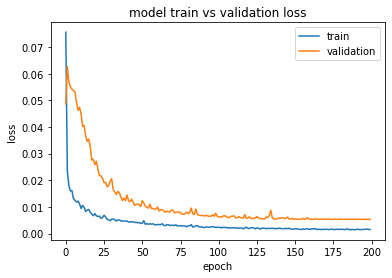

In [23]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [45]:
#predicting 246 values, using past 60 from the train data
inputs = data2.iloc[len(data2) - len(valid_set) - 60:,1:3].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = sc_valid.transform(inputs)

In [47]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [52]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = regressor.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-1]), axis=1)
closing_price = sc_valid.inverse_transform(inv_yhat)

ValueError: operands could not be broadcast together with shapes (147,6) (2,) (147,6) 

In [53]:
inv_yhat

array([[0.69232106, 0.690907  , 0.69009173, 0.69529295, 0.69332445,
        0.67382808],
       [0.40480718, 0.403844  , 0.39815924, 0.41059008, 0.40539074,
        0.32675411],
       [0.40134442, 0.40189302, 0.39932966, 0.407875  , 0.40391946,
        0.41623752],
       [0.37678075, 0.37788805, 0.37662715, 0.38268036, 0.38000831,
        0.37870713],
       [0.40127742, 0.40241933, 0.40281332, 0.40578312, 0.40481809,
        0.43173637],
       [0.46004647, 0.46060351, 0.46255973, 0.46283877, 0.4633185 ,
        0.50814704],
       [0.37385845, 0.37368739, 0.37372428, 0.37665439, 0.37642634,
        0.37564005],
       [0.36188176, 0.36164695, 0.3617447 , 0.36467254, 0.36433309,
        0.39217656],
       [0.37893623, 0.37866783, 0.37928286, 0.38133913, 0.38129416,
        0.39653659],
       [0.36300895, 0.36269885, 0.36288834, 0.36533505, 0.36517897,
        0.35758652],
       [0.37160996, 0.37137586, 0.37169433, 0.37373722, 0.37374714,
        0.371932  ],
       [0.44048733, 0

In [ ]:
lstm_sma_rms=np.sqrt(np.mean(np.power((valid_set-closing_price),2)))
lstm_sma_rms

In [ ]:
#for plotting
train = data2[:750]
valid = data2[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.xticks(rotation=45)

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])